In [22]:
import numpy as np
import tensorflow.contrib.slim as slim
import scipy.signal
import gym
import os
import threading
import multiprocessing
import tensorflow as tf
import ac_network
import worker
import matplotlib.pyplot as plt
import replay_buffer
import gym_wrapper

reload(ac_network)
reload(worker)
reload(replay_buffer)
reload(gym_wrapper)

from gym_wrapper import GymWrapper
from ac_network import AC_Network
from worker import Worker
from replay_buffer import ReplayBuffer

** Setup of hyperparameters **

In [23]:
# Tensorboard dir
LOG_DIR = '/home/adrian/Schreibtisch/Uni/Data-Innovation-Lab/DILAB/tensorflowlogs'

# Gym environment
ENV_NAME = 'CartPole-v0'  # Discrete (4, 2)
RANDOM_SEED = 1234
STATE_DIM = 4
ACTION_DIM = 2

# Neural network spec
CELL_UNITS = 16
# Learning rate
LEARNING_RATE = 0.0005

# Exploration spec
ENTROPY_REGULARIZATION = True
ENTROPY_REGULARIZATION_LAMBDA = 0.1
# Noisy net settings 
# 1.Option --> None (normal fully connected layers)
# 2.Option --> "factorized"
# 3.Option --> "independent"
NOISE_DIST = 'factorized'

# Size of mini batches to run training on
MINI_BATCH = 40
REWARD_FACTOR = 0.001
# Discount rate for advantage estimation and reward discounting
GAMMA = 0.99
EPISODE_RUNS = 1000

METHOD = "A3C"
TAU = 0.2
ROLLOUT = 10

# Define network configuration
network_config = dict(shared = True,
                      shared_config = dict(kind = 'RNN',
                                           Cell_Units = 16),
                      policy_config = dict(layers = [2],
                                           noise_dist = "factorized"),
                      value_config = dict(layers = [1],
                                          noise_dist = "factorized"))

In [24]:
#MAIN
#def main(_):
global master_network
global global_episodes

tf.reset_default_graph()

with tf.device('/job:local/task:0/device:CPU:0'): #Parameter server adress
    RANDOM_SEED = 1234
    np.random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)

    global_episodes = tf.Variable(0, dtype=tf.int32, name='global_episodes', trainable=False)
    trainer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)
    master_network = AC_Network(STATE_DIM, ACTION_DIM, 'global', None, network_config, tau = TAU, rollout = ROLLOUT, method = METHOD)  # Generate global network
    num_workers = 2  # Number of workers

    workers = []
    # Create worker classes
    with tf.device('/job:local/task:1/device:CPU:0'): #Worker server adresses
        workers.append(Worker(0, STATE_DIM, ACTION_DIM, network_config, trainer, global_episodes,
                              ENV_NAME, tau = TAU, rollout = ROLLOUT, method = METHOD))
    with tf.device('/job:local/task:1/device:CPU:0'):
        workers.append(Worker(1, STATE_DIM, ACTION_DIM, network_config,trainer,global_episodes,
                              ENV_NAME, tau = TAU, rollout = ROLLOUT, method = METHOD))

with tf.Session("grpc://localhost:2222") as sess:
    coord = tf.train.Coordinator()
    merged = tf.summary.merge_all()    
    train_writer = tf.summary.FileWriter(LOG_DIR, sess.graph)
    sess.run(tf.global_variables_initializer())

    # This is where the asynchronous magic happens.
    # Start the "work" process for each worker in a separate thread.
    worker_threads = []
    worker=workers[0]
    with tf.device('/job:local/task:1/device:CPU:0'):
        worker_work = lambda: worker.work(GAMMA, sess, coord, merged, train_writer)
        t = threading.Thread(target=(worker_work))
        t.start()
    worker_threads.append(t)
    worker=workers[1]
    with tf.device('/job:local/task:1/device:CPU:0'):
        worker_work = lambda: worker.work(GAMMA, sess, coord, merged, train_writer)
        t = threading.Thread(target=(worker_work))
        t.start()
    worker_threads.append(t)
    print("Start")
    coord.join(worker_threads)

#tf.app.run()


A3C
A3C
Start
Starting worker 0
Starting worker 1
('Reward: 15.2', ' | Episode', 0, ' of worker_1')
('Reward: 19.8', ' | Episode', 0, ' of worker_0')
('Reward: 23.6', ' | Episode', 20, ' of worker_0')
('Reward: 23.2', ' | Episode', 20, ' of worker_1')
('Reward: 25.2', ' | Episode', 40, ' of worker_0')
('Reward: 21.0', ' | Episode', 40, ' of worker_1')


Exception in thread Thread-24:
Traceback (most recent call last):
  File "/home/adrian/anaconda3/envs/py27/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/home/adrian/anaconda3/envs/py27/lib/python2.7/threading.py", line 754, in run
    self.__target(*self.__args, **self.__kwargs)
  File "<ipython-input-24-65be2922b6de>", line 44, in <lambda>
    worker_work = lambda: worker.work(GAMMA, sess, coord, merged, train_writer)
  File "worker.py", line 378, in work
    a, v, rnn_state, _ = self.act(s, rnn_state, sess)
  File "worker.py", line 267, in act
    self.local_AC.state_in[1]: rnn_state[1]})
  File "/home/adrian/anaconda3/envs/py27/lib/python2.7/site-packages/tensorflow/python/client/session.py", line 889, in run
    run_metadata_ptr)
  File "/home/adrian/anaconda3/envs/py27/lib/python2.7/site-packages/tensorflow/python/client/session.py", line 1120, in _run
    feed_dict_tensor, options, run_metadata)
  File "/home/adrian/anaconda3/envs/py27/lib/py

KeyboardInterrupt: 

Get rewards collected by the different agents

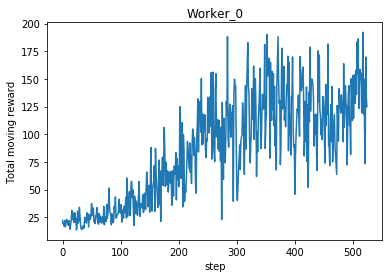

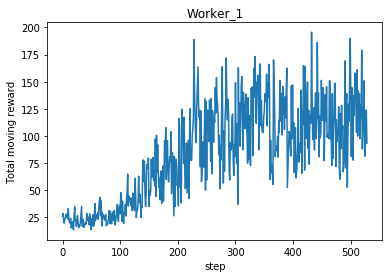

In [129]:
plotListNoNoisyNet = []
for i in range(len(workers)):
    workerTemp = workers[i]
    rewards = workerTemp.getRewards()
    plt.plot(np.arange(len(rewards)), rewards)
    plt.xlabel('step')
    plt.ylabel('Total moving reward')
    plt.title("Worker_%s" % i)
    plotListNoNoisyNet.append(plt)
    plt.show()

In [83]:
np.mean(rewards[-20:])

124.5

200.0


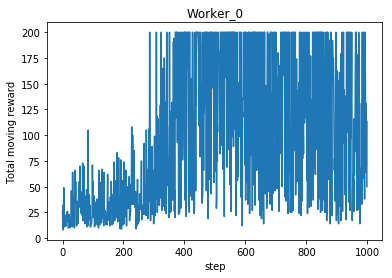

200.0


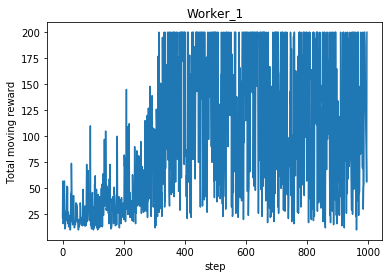

In [15]:
plotList = []
for i in range(len(workers)):
    workerTemp = workers[i]
    rewards = workerTemp.getRewards()
    print(np.max(rewards))
    plt.plot(np.arange(len(rewards)), rewards)
    plt.xlabel('step')
    plt.ylabel('Total moving reward')
    plt.title("Worker_%s" % i)
    plotList.append(plt)
    plt.show()

In [75]:
actions = np.random.binomial(1, 0.5, size = (5,24,2)) 
discount = np.array([GAMMA**i for i in range(10)], dtype=np.float32)
rewards = np.random.binomial(5, 0.5, size = (5,24))

init_c = np.zeros(shape = (5, 16))
init_h = np.zeros(shape = (5, 16))
process_ = np.random.normal(size = (5,24,4))

feed_dict_ = {
    ac_network_test_.inputs:process_,
    ac_network_test_.state_in[0]:init_c,
    ac_network_test_.state_in[1]:init_h,
    ac_network_test_.actions:actions
    #ac_network_test_.rewards:rewards,
    #ac_network_test_.discount:discount,
    #ac_network_test_.rollout:10
}

pol_, val_ = sess.run([ac_network_test_.policy, ac_network_test_.value], feed_dict = feed_dict_)

In [76]:
np.shape(pol_)

(5, 24, 2)

Develop batched loss function

In [70]:
tf.reset_default_graph()
sess = tf.Session()

vals = tf.placeholder(shape=[None, None], dtype=tf.float32)
actions_ = tf.placeholder(shape=[None, None, 2], dtype=tf.float32)
policy_ = tf.placeholder(shape=[None, None, 2], dtype=tf.float32)
rewards_ = tf.placeholder(shape=[None, None], dtype=tf.float32)

length_ep = tf.placeholder(shape=[None], dtype=tf.int32)
rollout_ = tf.placeholder(tf.int32, shape = ())
discount_ = tf.placeholder(shape=[None], dtype=tf.float32)


batch_size = tf.shape(vals)[0]
length_ep_ = tf.shape(vals)[1]


init_array = tf.TensorArray(tf.float32, size=batch_size)
init_array_means = tf.TensorArray(tf.float32, size=batch_size)
# value_loss_array holds for every episode -value_first + gamma ** rollout * value_last
def compute_value_loss(i, ta, ta_mean):
    value_loss = -1 * vals[i][:(length_ep[i] - 10 + 1)] + discount_[rollout_ - 1] * vals[i][-(length_ep[i] + (length_ep_-length_ep[i]) - rollout_ + 1):length_ep[i]]
    value_loss_mean = tf.reduce_mean(value_loss)
    return i + 1, ta.write(i, value_loss), ta_mean.write(i, value_loss_mean)

_, value_loss_array, value_loss_mean_array = tf.while_loop(
    lambda i, ta, ta_mean: i < batch_size, compute_value_loss, [0, init_array, init_array_means])

# Compute now 

policy_loss_array_init = tf.TensorArray(tf.float32, size=batch_size)
    policy_loss_mean_array_init = tf.TensorArray(tf.float32, size=batch_size)
def compute_policy_loss(i, ta, ta_mean):
    # Compute log probs
    log_probs = tf.log(tf.reduce_sum(actions_[i][:length_ep[i]] * policy_[i][:length_ep[i]], axis=1) + 0.0001)
    # Compute rolling log_probs
    rolling_log_probs = tf.map_fn(lambda j: log_probs[j:(j + rollout_ - 1)],
                              tf.range(length_ep[i] - rollout_ + 1), dtype=tf.float32)
    # Compute rolling rewards
    rolling_rewards = tf.map_fn(lambda j: rewards_[i][j:(j + rollout_ - 1)],
                              tf.range(length_ep[i] - rollout_ + 1), dtype=tf.float32)
    
    # Compute policy loss
    policy_loss = tf.reduce_sum((rolling_rewards - 0.2 *
                                 rolling_log_probs) * discount_[:(rollout_ -1)], axis=1)
    
    policy_loss_mean = tf.reduce_mean(policy_loss)
    
    return i + 1, ta. write(i, policy_loss), ta_mean.write(i, policy_loss_mean)

# Loop over all episodes
_, policy_loss_array, policy_loss_array_mean = tf.while_loop(
    lambda i, ta, ta_mean: i < batch_size, compute_policy_loss, [0, policy_loss_array_init, policy_loss_mean_array_init])
    

tf_loss_map_ = tf.map_fn(lambda i: tf.reduce_mean(0.5 * tf.square(value_loss_array.gather([i]) + policy_loss_array.gather([i]))),
                       tf.range(batch_size), dtype = tf.float32)

# Compute final weighted loss of all episodes
tf_loss_final_ = tf.reduce_sum(tf_loss_map_ * tf.cast(length_ep, dtype=tf.float32))/tf.cast(tf.reduce_sum(length_ep), dtype=tf.float32)

tf_loss_mean = tf.reduce_sum(tf.map_fn(lambda i: value_loss_mean_array.gather([i]),
                                       tf.range(batch_size),
                                       dtype = tf.float32) * tf.cast(length_ep, dtype=tf.float32))/tf.cast(tf.reduce_sum(length_ep), dtype=tf.float32)


#tf_loss_value_1 = value_loss_mean_array.gather([0])
#tf_loss_value_2 = value_loss_mean_array.gather([1])

tf_loss_policy_1 = policy_loss_array_mean.gather([0])
tf_loss_policy_2 = policy_loss_array_mean.gather([1])

In [71]:
feed_dict_ = {
    vals:np.reshape(val_, newshape=(3,24)),
    length_ep:np.array([24,20,18]),
    rollout_:10,
    discount_:discount,
    actions_:actions,
    policy_:pol_,
    rewards_: rewards
}

a,b = sess.run([tf_loss_mean, tf_loss_policy_1], feed_dict_)

In [68]:
def rolloutPCL(initial_state, rnn_state, env, max_path_length=None, episode_count = 1):

    # Perform rollout of given environment
    if max_path_length is None:
        max_path_length = env.spec.tags.get(
            'wrapper_config.TimeLimit.max_episode_steps')

    # Define list so save episodes
    episodes = []

    for i in range(episode_count):
        rnn_state_rolling = rnn_state
        if i > 0:
            # First initial state is supplied
            initial_state = env.reset()
        states = []
        actions = []
        rewards = []
        agent_infos = []
        env_infos = []
        values = []
        s = np.reshape(initial_state, newshape=[1,len(initial_state)])
        path_length = 0

        # Sample one episode
        while path_length < max_path_length:
            s_reshape = np.reshape(s, newshape=[1,STATE_DIM])
            a, v, rnn_state_rolling, agent_info = act(s_reshape, rnn_state_rolling, sess)
            next_s, r, d, env_info = env.step(np.argmax(a))
            states.append(np.squeeze(s_reshape))
            rewards.append(r)
            values.append(np.squeeze(v))
            actions.append(np.argmax(a))
            agent_infos.append(agent_info)
            env_infos.append(env_info)
            path_length += 1
            if d:
                break
            s = next_s
        # Append sampled episode
        action_array = np.eye(ACTION_DIM, dtype=np.int32)[np.array(actions)]
        episodes.append(dict(
                                states=np.expand_dims(np.array(states), 0),
                                actions=np.expand_dims(np.array(action_array),0),
                                rewards=np.expand_dims(np.array(rewards),0),
                                values = np.expand_dims(np.reshape(np.array(values), newshape= (len(np.array(values)))), 0),
                                agent_infos=np.expand_dims(np.array(agent_infos),0),
                                env_infos=np.expand_dims(np.array(env_infos),0)
                            ))
    return episodes

def weighted_pick(weights,n_picks):
    t = np.cumsum(weights)
    s = np.sum(weights)
    return np.searchsorted(t,np.random.rand(n_picks)*s)

def act(state, rnn_state, sess):

    action_dist, value, rnn_state = sess.run([ac_network_test_.policy, ac_network_test_.value, ac_network_test_.state_out],
                                    feed_dict={ac_network_test_.inputs: [state],
                                               ac_network_test_.state_in[0]: rnn_state[0],
                                               ac_network_test_.state_in[1]: rnn_state[1]})

    # Chose action with largest probability
    a0 = weighted_pick(action_dist[0], 1)  # Use stochastic distribution sampling
    action_one_hot = np.zeros(ACTION_DIM)
    action_one_hot[a0] = 1

    return action_one_hot, value, rnn_state, action_dist


In [ ]:
rolloutPCL()

In [77]:
env_ = gym.make(ENV_NAME)
initial_state = env_.reset()
s = np.reshape(initial_state, newshape=[1,len(initial_state)])
eps = rolloutPCL(initial_state, val_, env_, episode_count=5)

ValueError: Cannot feed value of shape (24, 1) for Tensor u'worker_0/Placeholder_1:0', which has shape '(?, 16)'

In [31]:
print(np.shape(eps[0]["actions"]))
print(np.shape(eps[0]["states"]))
print(np.shape(eps[0]["rewards"]))
print(np.shape(eps[0]["values"]))
print(np.shape(eps[0]["agent_infos"]))
print(np.shape(eps[0]["env_infos"]))

(1, 10, 2)
(1, 10, 4)
(1, 10)
(1, 10)
(1, 10, 1, 1, 2)
(1, 10)


In [20]:
replay_buffer_PCL = ReplayBuffer()
replay_buffer_PCL.add(eps)

In [47]:
sampled_eps = replay_buffer_PCL.sample(3)
max_len = max([len(ep["actions"][0]) for ep in sampled_eps])

states_start = np.pad(sampled_eps[0]["states"], [(0, 0), (0, max_len-np.shape(sampled_eps[0]["states"])[1]), (0,0)], mode='constant')
actions_start =  np.pad(sampled_eps[0]["actions"], [(0, 0), (0, max_len-np.shape(sampled_eps[0]["actions"])[1]), (0,0)], mode='constant')
values_start = np.pad(sampled_eps[0]["values"], [(0, 0), (0, max_len-np.shape(sampled_eps[0]["values"])[1])], mode='constant')
rewards_start = np.pad(sampled_eps[0]["rewards"], [(0, 0), (0, max_len-np.shape(sampled_eps[0]["rewards"])[1])], mode='constant')

for i in range(len(sampled_eps) - 1):
    states_start = np.concatenate((states_start, np.pad(sampled_eps[i+1]["states"], 
                                                        [(0, 0), (0, max_len-np.shape(sampled_eps[i+1]["states"])[1]), (0,0)], mode='constant')),
                                  axis = 0)
    actions_start = np.concatenate((actions_start, np.pad(sampled_eps[i+1]["actions"], 
                                                        [(0, 0), (0, max_len-np.shape(sampled_eps[i+1]["actions"])[1]), (0,0)], mode='constant')),
                                  axis = 0)
    values_start = np.concatenate((values_start, np.pad(sampled_eps[i+1]["values"], 
                                                        [(0, 0), (0, max_len-np.shape(sampled_eps[i+1]["values"])[1])], mode='constant')),
                                  axis = 0)
    rewards_start = np.concatenate((rewards_start, np.pad(sampled_eps[i+1]["rewards"], 
                                                        [(0, 0), (0, max_len-np.shape(sampled_eps[i+1]["rewards"])[1])], mode='constant')),
                                  axis = 0)

In [28]:
env_count = 10

actions = np.random.binomial(1, 0.5, size = (env_count,1,2)) 
discount = np.array([GAMMA**i for i in range(10)], dtype=np.float32)
rewards = np.random.binomial(5, 0.5, size = (env_count,1))

init_c = np.zeros(shape = (env_count, 16))
init_h = np.zeros(shape = (env_count, 16))
process_ = np.random.normal(size = (env_count,1,4))
#process_ = np.reshape(process_, newshape= [3,1,4])

feed_dict_ = {
    ac_network_test_.inputs:process_,
    ac_network_test_.state_in[0]:init_c,
    ac_network_test_.state_in[1]:init_h,
    ac_network_test_.actions:actions,
    ac_network_test_.rewards:rewards,
    ac_network_test_.discount:discount,
    ac_network_test_.rollout:10
}

pol_, val_ , rnn_state = sess.run([ac_network_test_.policy, ac_network_test_.value, ac_network_test_.state_out], feed_dict = feed_dict_)

In [29]:
print(np.shape(pol_))
print(np.shape(val_))
print(np.shape(rnn_state))

(10, 1, 2)
(10, 1, 1)
(2, 10, 16)


Define Gym Wrapepr

In [30]:
# Weighted random selection returns n_picks random indexes.
# the chance to pick the index i is give by the weight weights[i].
def weighted_pick(weights,n_picks):
    t = np.cumsum(weights)
    s = np.sum(weights)
    return np.searchsorted(t,np.random.rand(n_picks)*s)

actions = [weighted_pick(a,1) for a in pol_]
action_one_hot = np.eye(ACTION_DIM, dtype=np.int32)[np.array(actions)]

Get actions for every step

In [32]:
act_ = [np.argmax(a) for a in action_one_hot]

In [93]:
np.shape(action_one_hot)

(10, 1, 2)

Define 10 independent envs

In [7]:
envs_cart = GymWrapper(ENV_NAME, count = 10)
initial_obs = envs_cart.reset()

Perform one step in every env

In [140]:
next_obs, reward_class, done_class, tt_class , out_= envs_cart.step(act_)
reward_class = np.expand_dims(reward_class, 1)
print(np.shape(next_obs))
print(np.shape(reward_class))
print(np.shape(done_class))
print(np.shape(val_))

(10, 1, 4)
(10, 1)
(10,)
(10, 1, 1)


In [141]:
episode_buffer = []
episode_buffer.append([initial_obs, action_one_hot, reward_class])
episode_buffer.append([next_obs, action_one_hot, reward_class])

In [178]:
episode_states = np.array([], dtype=np.float32).reshape(10,0,4)
episode_reward = np.array([], dtype=np.float32).reshape(10,0)



In [187]:
np.expand_dims(np.squeeze(val_), 1)

(10, 1)

In [174]:
new = np.concatenate((asd, initial_obs), 1)
np.shape(np.concatenate((next_obs, new), 1))

(10, 2, 4)

In [180]:
np.shape(np.concatenate((episode_reward, reward_class), 1))

(10, 1)

In [188]:
len(envs)

10

**** A3C Batch ****

In [74]:
tf.reset_default_graph()
sess = tf.Session()
trainer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)
ac_network_test = AC_Network(STATE_DIM, ACTION_DIM, "global", None, network_config, TAU, ROLLOUT, METHOD)
ac_network_test_ = AC_Network(STATE_DIM, ACTION_DIM, "worker_0", trainer, network_config, TAU, ROLLOUT, METHOD)

sess.run(tf.global_variables_initializer())

In [52]:
envs_cart = GymWrapper(ENV_NAME, count = 10)

episode_states_train = np.array([], dtype=np.float32).reshape(len(envs_cart),0,STATE_DIM)
episode_reward_train = np.array([], dtype=np.float32).reshape(len(envs_cart),0)
episode_actions_train = np.array([], dtype=np.float32).reshape(len(envs_cart),0, ACTION_DIM)
episode_values_train = np.array([], dtype=np.float32).reshape(len(envs_cart),0)
episode_done_train = np.array([], dtype=np.float32).reshape(len(envs_cart),0)
episode_reward = []
episode_values = []

def weighted_pick(weights,n_picks):
    t = np.cumsum(weights)
    s = np.sum(weights)
    return np.searchsorted(t,np.random.rand(n_picks)*s)

env_count = len(envs_cart)
s = envs_cart.reset()
init_c = np.zeros(shape = (env_count, 16))
init_h = np.zeros(shape = (env_count, 16))
    
for i in range(40):
    env_count = 10
    
    discount = np.array([GAMMA**i for i in range(10)], dtype=np.float32)

    process_ = np.random.normal(size = (env_count,1,4))
    #process_ = np.reshape(process_, newshape= [3,1,4])

    feed_dict_ = {
        ac_network_test_.inputs:s,
        ac_network_test_.state_in[0]:init_c,
        ac_network_test_.state_in[1]:init_h,
    }

    action_dist, v , rnn_state = sess.run([ac_network_test_.policy, ac_network_test_.value, ac_network_test_.state_out],
                                      feed_dict = feed_dict_)

    a0 = [weighted_pick(a,1) for a in action_dist]  # Use stochastic distribution sampling
    action_one_hot = np.eye(ACTION_DIM, dtype=np.int32)[np.array(a0)]
    act_ = [np.argmax(a_) for a_ in action_one_hot]
    
    s_next, r, done, tt_class  = envs_cart.step(act_)
    episode_reward.append(r)
    episode_values.append(v)
    
    episode_states_train = np.concatenate((episode_states_train, s), 1)
    episode_reward_train = np.concatenate((episode_reward_train, np.expand_dims(r, 1)), 1)
    episode_actions_train = np.concatenate((episode_actions_train, action_one_hot), 1)
    episode_values_train = np.concatenate((episode_values_train, np.expand_dims(np.squeeze(v), 1)), 1)
    episode_done_train = np.concatenate((episode_done_train, np.expand_dims(done, 1)), 1)

    s = s_next
    init_c = rnn_state[0]
    init_h = rnn_state[1]

v1 = np.squeeze(sess.run([ac_network_test_.value],
                feed_dict={ac_network_test_.inputs: s,
                            ac_network_test_.state_in[0]: rnn_state[0],
                            ac_network_test_.state_in[1]: rnn_state[1]}))

    
    
print(np.shape(episode_states_train))
print(np.shape(episode_actions_train))
print(np.shape(episode_reward_train))
print(np.shape(episode_values_train))
print(np.shape(episode_done_train))
print(np.shape(rnn_state))

(10, 40, 4)
(10, 40, 2)
(10, 40)
(10, 40)
(10, 40)
(2, 10, 16)


In [57]:
np.mean(np.sum(episode_values, axis = 0))

2.9853594

In [51]:
np.mean(np.sum(episode_reward, axis=0))

19.6

In [12]:
def discounting(x, gamma):
    return scipy.signal.lfilter([1], [1, -gamma], x[::-1], axis=0)[::-1]

states = episode_states_train
rewards = episode_reward_train
actions = episode_actions_train
values = episode_values_train
terminal = episode_done_train
gamma = 0.95
r = v1

# Get length of different rollouts --> Since given e.g. 10 envs maybe 5 terminated earlier
lengths_rollouts = [int(-1 * sum(done - 1)) for done in terminal]

# Get batch size
batch_size = len(states)

# Max len batch
max_len = len(states[0])

# Here we take the rewards and values from the rollout, and use them to
# generate the advantage and discounted returns.
rewards_list = [np.asarray(rewards[i].tolist()[:lengths_rollouts[i]]+[r[i]]) * 0.001 for i in range(batch_size)]
discounted_rewards = [discounting(rewards_list[i], gamma)[:-1] for i in range(batch_size)]

# Advantage estimation
# JS, P Moritz, S Levine, M Jordan, P Abbeel,
# "High-dimensional continuous control using generalized advantage estimation."
# arXiv preprint arXiv:1506.02438 (2015).
values_list = [np.asarray(values[i].tolist()[:lengths_rollouts[i]]+[r[i]]) * 0.001 for i in range(batch_size)]

# Compute TD residual of V with discount gamma --> can be considered as the advantage of the action a_t
advantages = [rewards[i][:lengths_rollouts[i]] + gamma * values_list[i][1:] - values_list[i][:-1] for i in range(batch_size)]
discounted_advantages = [discounting(advantages[i], gamma) for i in range(batch_size)]

padded_discounted_advantages = [np.pad(discounted_advantages[i], [(0, max_len - lengths_rollouts[i])], mode = "constant") for i in range(batch_size)]
padded_discounted_advantages = np.vstack(padded_discounted_advantages)

padded_discounted_rewards = [np.pad(discounted_rewards[i], [(0, max_len - lengths_rollouts[i])], mode="constant") for i in range(batch_size)]
padded_discounted_rewards = np.stack(padded_discounted_rewards)


In [19]:
tf.reset_default_graph()
sess = tf.Session()

#policy = actions = tf.placeholder(shape=[None, None, 1], dtype=tf.float32)
value = actions = tf.placeholder(shape=[None, None], dtype=tf.float32)
actions = tf.placeholder(shape=[None, None, 2], dtype=tf.float32)
target_v = tf.placeholder(shape=[None, None], dtype=tf.float32)
advantages = tf.placeholder(shape=[None, None], dtype=tf.float32)
seq_lens = tf.placeholder(shape=[None], dtype=tf.int32)

batch_size = tf.shape(target_v)[0]
max_len = tf.shape(target_v)[1]

value_loss_array_init = tf.TensorArray(tf.float32, size=batch_size)

def compute_value_loss(i, ta):
    value_loss_temp = 0.5 * tf.reduce_sum(tf.square(target_v[i][:seq_lens[i]] - value[i][:seq_lens[i]]))
    return i +1, ta.write(i, value_loss_temp)

# Loop over all episodes
_, value_loss_array = tf.while_loop(
    lambda i, ta: i < batch_size, compute_value_loss, [0, value_loss_array_init])

val_1 = value_loss_array.gather([1])

In [20]:
feed_dict_ = {
    #policy: 
    value: episode_values_train,
    actions: episode_actions_train,
    target_v: padded_discounted_rewards,
    advantages: padded_discounted_advantages,
    seq_lens: lengths_rollouts
}

sess.run([val_1], feed_dict_)

[array([0.17833658], dtype=float32)]

In [400]:
print(np.shape(padded_discounted_rewards))
print(np.shape(padded_discounted_advantages))
print(np.shape(actions))
print(np.shape(states))

(10, 40)
(10, 40)
(10, 40, 2)
(10, 40, 4)
